In [1]:
import mne
import os
from mne.preprocessing import ICA
from mne.preprocessing import create_eog_epochs, create_ecg_epochs
from mne.preprocessing import read_ica
from mne.beamformer import apply_lcmv, make_lcmv
from preprocessing import Preprocessing
from mne import compute_raw_covariance
from datahandling import BcomMEG
from wavelets import *
import matplotlib.pyplot as plt

In [13]:
data.data[subject]['te_64'].crop(tmin=-0.2, tmax=0.6)

<EpochsFIF | 10 events (all good), -0.2 – 0.6 s (baseline off), ~8.1 MB, data loaded,
 '64': 10>

In [97]:
empty_room = mne.io.read_raw_fif(
    "/Volumes/BCOM/ciprian_project/data_analyzed/preprocessed/BCOM_01/2/empty_room_cleaned_ICA_raw.fif",
    preload=True
    )
empty_room.info['bads']
bad_loc_channel = "MEG 173"
empty_room.interpolate_bads(exclude=[bad_loc_channel], origin=(0., 0., 0.))

Opening raw data file /Volumes/BCOM/ciprian_project/data_analyzed/preprocessed/BCOM_01/2/empty_room_cleaned_ICA_raw.fif...
Isotrak not found
    Range : 0 ... 89999 =      0.000 ...   179.998 secs
Ready.
Reading 0 ... 89999  =      0.000 ...   179.998 secs...
Setting channel interpolation method to {'meg': 'MNE'}.
Interpolating bad channels.
    Computing dot products for 244 MEG channels...
    Computing cross products for 244 → 3 MEG channels...
    Preparing the mapping matrix...
    Truncating at 88/244 components to omit less than 0.0001 (9.6e-05)


<Raw | empty_room_cleaned_ICA_raw.fif, 280 x 90000 (180.0 s), ~192.5 MB, data loaded>

In [98]:
noise_cov = compute_raw_covariance(empty_room, 
                                   method='auto',
                                   rank=None, 
                                   picks="meg")

Using up to 900 segments
Using data from preloaded Raw for 900 events and 100 original time points ...
0 bad epochs dropped
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 247 -> 244
Estimating covariance using SHRUNK
Done.
Estimating covariance using DIAGONAL_FIXED
    MAG regularization : 0.1
Done.
Estimating covariance using EMPIRICAL
Done.
Using cross-validation to select the best estimator.
    MAG regularization : 0.1
    MAG regularization : 0.1
    MAG regularization : 0.1
Number of samples used : 90000
log-likelihood on unseen data (descending order):
   shrunk: -1366.306
   diagonal_fixed: -1384.316
   empirical: -1440.840
selecting best estimator: shrunk
[done]


In [99]:
print(noise_cov)
import numpy as np
print("Max:", np.max(noise_cov.data))
print("Min:", np.min(noise_cov.data))
print("Mean:", np.mean(noise_cov.data))
print("Non-zero entries:", np.count_nonzero(noise_cov.data))
print("Total number of entries", noise_cov.data.shape[0]*noise_cov.data.shape[1])

<Covariance | kind : full, shape : (247, 247), range : [-2.9e-26, +6.5e-26], n_samples : 89999>
Max: 6.526209886763194e-26
Min: -2.874467904175791e-26
Mean: 2.7548969836782203e-27
Non-zero entries: 61009
Total number of entries 61009


Computing rank from covariance with rank=None
    Using tolerance 9.7e-14 (2.2e-16 eps * 247 dim * 1.8  max singular value)
    Estimated rank (mag): 244
    MAG: rank 244 computed from 247 data channels with 0 projectors


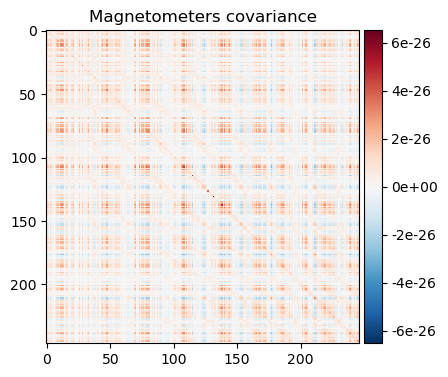

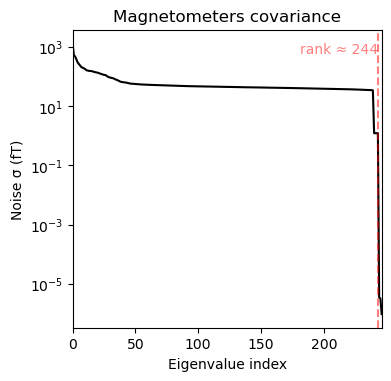

(<Figure size 380x370 with 2 Axes>, <Figure size 380x370 with 1 Axes>)

In [100]:
mne.viz.plot_cov(noise_cov, empty_room.info)

## Reconstruction

In [2]:
scaled = "scaled_fsaverage"
subject = "BCOM_01_2"

In [172]:
for subject in data.data:
    for syllable in data.data[subject]:
        print(data.data[subject][syllable])


<EpochsFIF | 10 events (all good), -0.4 – 0.8 s (baseline off), ~11.9 MB, data loaded,
 '64': 10>
<EpochsFIF | 13 events (all good), -0.4 – 0.8 s (baseline off), ~15.3 MB, data loaded,
 '46': 13>
<EpochsFIF | 11 events (all good), -0.4 – 0.8 s (baseline off), ~13.0 MB, data loaded,
 '36': 11>
<EpochsFIF | 7 events (all good), -0.4 – 0.8 s (baseline off), ~8.5 MB, data loaded,
 '24': 7>
<EpochsFIF | 18 events (all good), -0.4 – 0.8 s (baseline off), ~20.9 MB, data loaded,
 '32': 18>
<EpochsFIF | 6 events (all good), -0.4 – 0.8 s (baseline off), ~7.3 MB, data loaded,
 '66': 6>
<EpochsFIF | 12 events (all good), -0.4 – 0.8 s (baseline off), ~14.1 MB, data loaded,
 '14': 12>
<EpochsFIF | 13 events (all good), -0.4 – 0.8 s (baseline off), ~15.3 MB, data loaded,
 '52': 13>
<EpochsFIF | 13 events (all good), -0.4 – 0.8 s (baseline off), ~15.3 MB, data loaded,
 '62': 13>
<EpochsFIF | 14 events (all good), -0.4 – 0.8 s (baseline off), ~16.4 MB, data loaded,
 '26': 14>
<EpochsFIF | 14 events (al

In [102]:
morphed_bem = f"/Users/ciprianbangu/mne_data/MNE-fsaverage-data/{scaled}_{subject}/bem/{scaled}_{subject}-5120-5120-5120-bem-sol.fif"
morphed_source = f"/Users/ciprianbangu/mne_data/MNE-fsaverage-data/{scaled}_{subject}/bem/{scaled}_{subject}-ico-5-src.fif"
morphed_trans = f"/Users/ciprianbangu/Cogmaster/M2 Internship/BCI code/trans/{subject}-trans.fif"


fs_dir = mne.datasets.fetch_fsaverage(verbose=True)
subjects_dir = os.path.dirname(fs_dir)

0 files missing from root.txt in /Users/ciprianbangu/mne_data/MNE-fsaverage-data
0 files missing from bem.txt in /Users/ciprianbangu/mne_data/MNE-fsaverage-data/fsaverage


In [3]:
dir = '/Volumes/BCOM/ciprian_project/data_analyzed/normalized/data/WITHOUT_BADS/COVERT'
subjects = [subject]
picks = None

data = BcomMEG(dir=dir, subjects=subjects, picks=picks, avoid_reading=False, avoid_producing=True)

Reading /Volumes/BCOM/ciprian_project/data_analyzed/normalized/data/WITHOUT_BADS/COVERT/BCOM_01_2_te_64-epo.fif ...
    Found the data of interest:
        t =    -400.00 ...     800.00 ms
        0 CTF compensation matrices available
Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
Reading /Volumes/BCOM/ciprian_project/data_analyzed/normalized/data/WITHOUT_BADS/COVERT/BCOM_01_2_ri_46-epo.fif ...
    Found the data of interest:
        t =    -400.00 ...     800.00 ms
        0 CTF compensation matrices available
Not setting metadata
13 matching events found
No baseline correction applied
0 projection items activated
Reading /Volumes/BCOM/ciprian_project/data_analyzed/normalized/data/WITHOUT_BADS/COVERT/BCOM_01_2_mi_36-epo.fif ...
    Found the data of interest:
        t =    -400.00 ...     800.00 ms
        0 CTF compensation matrices available
Not setting metadata
11 matching events found
No baseline correction applied
0 proj

In [ ]:
data.data[subject]['sa_52']

<EpochsFIF | 13 events (all good), -0.4 – 0.8 s (baseline off), ~15.3 MB, data loaded,
 '52': 13>

In [ ]:
reading = data.data[subject]['sa_52']
print(reading)

for syllable, epochs in data.data[subject].items():
    if syllable != "sa_52":
        reading = mne.concatenate_epochs((reading, epochs))

# evoked_reading = evoked_reading.copy().apply_baseline((-0.2,0)).average()
evoked_reading=reading.copy().average()

<EpochsFIF | 13 events (all good), -0.4 – 0.8 s (baseline off), ~15.3 MB, data loaded,
 '52': 13>
Not setting metadata
23 matching events found
No baseline correction applied
Not setting metadata
36 matching events found
No baseline correction applied
Not setting metadata
47 matching events found
No baseline correction applied
Not setting metadata
54 matching events found
No baseline correction applied
Not setting metadata
72 matching events found
No baseline correction applied
Not setting metadata
78 matching events found
No baseline correction applied
Not setting metadata
90 matching events found
No baseline correction applied
Not setting metadata
103 matching events found
No baseline correction applied
Not setting metadata
117 matching events found
No baseline correction applied
Not setting metadata
131 matching events found
No baseline correction applied
Not setting metadata
143 matching events found
No baseline correction applied
Not setting metadata
148 matching events found
No b

No projector specified for this dataset. Please consider the method self.add_proj.


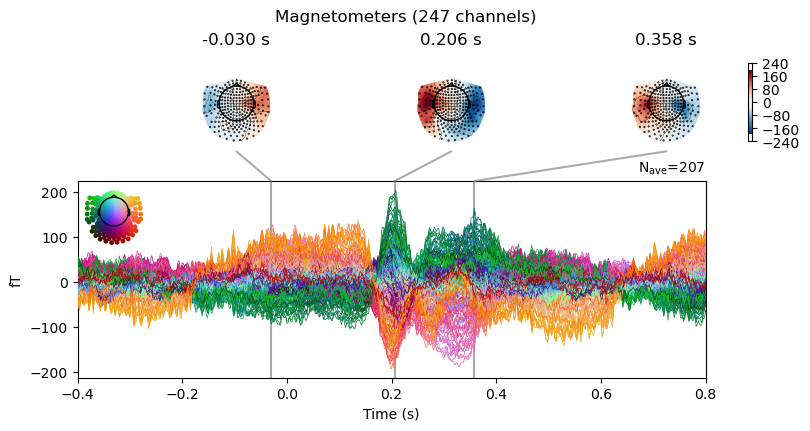

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Computing rank from covariance with rank=None
    Using tolerance 9.7e-14 (2.2e-16 eps * 247 dim * 1.8  max singular value)
    Estimated rank (mag): 244
    MAG: rank 244 computed from 247 data channels with 0 projectors
Computing rank from covariance with rank={'mag': 244}
    Setting small MAG eigenvalues to zero (without PCA)
    Created the whitener using a noise covariance matrix with rank 244 (3 small eigenvalues omitted)


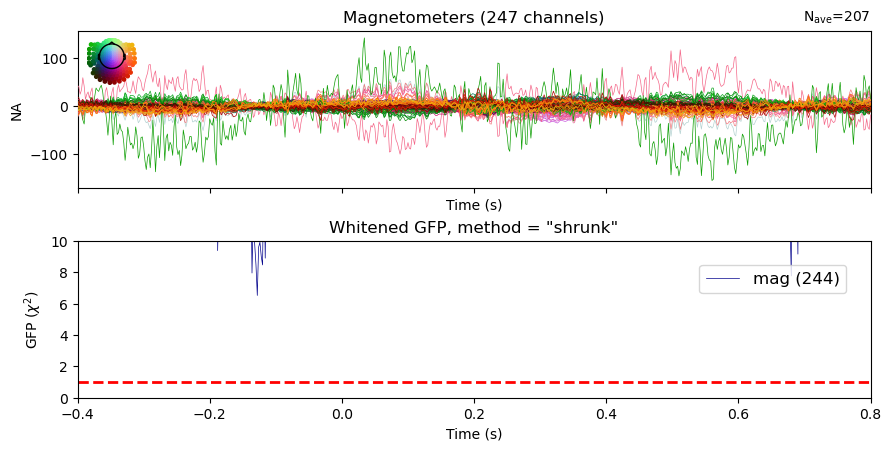

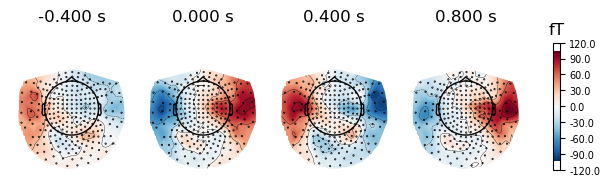

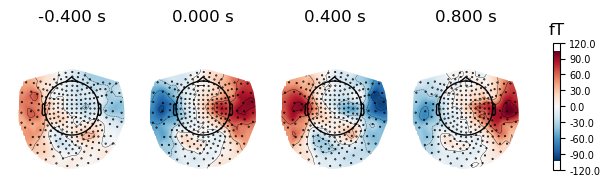

In [ ]:
evoked_reading.plot_joint()
evoked_reading.plot_white(noise_cov)
evoked_reading.plot_topomap(ch_type="mag")

In [ ]:
fwd = mne.make_forward_solution(
    evoked_reading.info,
    trans=morphed_trans,
    src=morphed_source, 
    bem=morphed_bem, 
    meg=True, 
    eeg=False
)

Source space          : /Users/ciprianbangu/mne_data/MNE-fsaverage-data/scaled_fsaverage_BCOM_01_2/bem/scaled_fsaverage_BCOM_01_2-ico-5-src.fif
MRI -> head transform : /Users/ciprianbangu/Cogmaster/M2 Internship/BCI code/trans/BCOM_01_2-trans.fif
Measurement data      : instance of Info
Conductor model   : /Users/ciprianbangu/mne_data/MNE-fsaverage-data/scaled_fsaverage_BCOM_01_2/bem/scaled_fsaverage_BCOM_01_2-5120-5120-5120-bem-sol.fif
Accurate field computations
Do computations in head coordinates
Free source orientations

Reading /Users/ciprianbangu/mne_data/MNE-fsaverage-data/scaled_fsaverage_BCOM_01_2/bem/scaled_fsaverage_BCOM_01_2-ico-5-src.fif...
Read 2 source spaces a total of 20484 active source locations

Coordinate transformation: MRI (surface RAS) -> head
    0.999667 -0.010944 -0.023385       1.50 mm
    0.010999 0.999937 0.002219      25.63 mm
    0.023359 -0.002476 0.999724      34.46 mm
    0.000000 0.000000 0.000000       1.00

Read 247 MEG channels from info
105 coil 

In [ ]:
#create inverse operator
inverse_operator = mne.minimum_norm.make_inverse_operator(
    evoked_reading.info, 
    fwd, 
    noise_cov, 
    loose=0.2, #surface so this is equivalent to auto - weights the source variances of the dipole components parallel to cortical surface, 
    depth=0.8, #actually this is ignored for eLoreta; but determines the weight of the forward using depth prior
)

Converting forward solution to surface orientation
    No patch info available. The standard source space normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 247 channels.
    247 out of 247 channels remain after picking
Selected 247 channels
Creating the depth weighting matrix...
    247 magnetometer or axial gradiometer channels
    limit = 20322/20484 = 10.048732
    scale = 3.58627e-11 exp = 0.8
Applying loose dipole orientations to surface source spaces: 0.2
Whitening the forward solution.
Computing rank from covariance with rank=None
    Using tolerance 9.7e-14 (2.2e-16 eps * 247 dim * 1.8  max singular value)
    Estimated rank (mag): 244
    MAG: rank 244 computed from 247 data channels with 0 projectors
    Setting small MAG eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matrix.
Computing SVD of whitene

In [ ]:
# applt inverse operator for all of the epochs
snr = 3.0 # idea that the signal is pretty noisy
lambda2 = 1.0/snr**2 # regularization parameter

stc = mne.minimum_norm.apply_inverse(
    evoked_reading,
    inverse_operator=inverse_operator,
    lambda2=lambda2,
    method='eLORETA'
)

Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 207
    Created the regularized inverter
    The projection vectors do not apply to these channels.
    Created the whitener using a noise covariance matrix with rank 244 (3 small eigenvalues omitted)
    Computing optimized source covariance (eLORETA)...
        Using independent orientation weights
        Fitting up to 20 iterations (this make take a while)...
        Converged on iteration 8 (5.4e-07 < 1e-06)
        Updating inverse with weighted eigen leads
[done]
Applying inverse operator to "0.06 × 52 + 0.05 × 64 + 0.06 × 46 + 0.05 × 36 + 0.03 × 24 + 0.09 × 32 + 0.03 × 66 + 0.06 × 14 + 0.06 × 62 + 0.07 × 26 + 0.07 × 42 + 0.06 × 34 + 0.02 × 54 + 0.08 × 22 + 0.04 × 44 + 0.03 × 56 + 0.06 × 16 + 0.08 × 12"...
    Picked 247 channels from the data
    Computing inverse...
    Eigenleads already weighted ... 
    Computing residual...
    Explained  94.6% variance
    Combining th

In [88]:
brain = stc.plot(hemi='both')

Using control points [6.12085729e-12 6.76178572e-12 1.24754001e-11]


qt.qpa.backingstore: Back buffer dpr of 1 doesn't match <NSViewBackingLayer: 0x3aa093fa0> contents scale of 2 - updating layer to match.
qt.qpa.backingstore: Back buffer dpr of 1 doesn't match <NSViewBackingLayer: 0x15505ecf0> contents scale of 2 - updating layer to match.
qt.qpa.backingstore: Back buffer dpr of 1 doesn't match <NSViewBackingLayer: 0x332e6d600> contents scale of 2 - updating layer to match.
qt.qpa.backingstore: Back buffer dpr of 1 doesn't match <NSViewBackingLayer: 0x332e6ea90> contents scale of 2 - updating layer to match.
qt.qpa.backingstore: Back buffer dpr of 1 doesn't match <NSViewBackingLayer: 0x332e73680> contents scale of 2 - updating layer to match.
qt.qpa.backingstore: Back buffer dpr of 1 doesn't match <NSViewBackingLayer: 0x332e74920> contents scale of 2 - updating layer to match.
qt.qpa.backingstore: Back buffer dpr of 1 doesn't match <NSViewBackingLayer: 0x332e752c0> contents scale of 2 - updating layer to match.
qt.qpa.backingstore: Back buffer dpr of 1

## let's try a beamformer

Reducing data rank from 247 -> 247
Estimating covariance using SHRUNK
Done.
Estimating covariance using DIAGONAL_FIXED
    MAG regularization : 0.1
Done.
Estimating covariance using EMPIRICAL
Done.
Using cross-validation to select the best estimator.
    MAG regularization : 0.1
    MAG regularization : 0.1
    MAG regularization : 0.1
Number of samples used : 51957
log-likelihood on unseen data (descending order):
   shrunk: -1355.637
   diagonal_fixed: -1404.940
   empirical: -1483.718
selecting best estimator: shrunk
[done]
Computing rank from covariance with rank=None
    Using tolerance 1.2e-13 (2.2e-16 eps * 247 dim * 2.1  max singular value)
    Estimated rank (mag): 247
    MAG: rank 247 computed from 247 data channels with 0 projectors


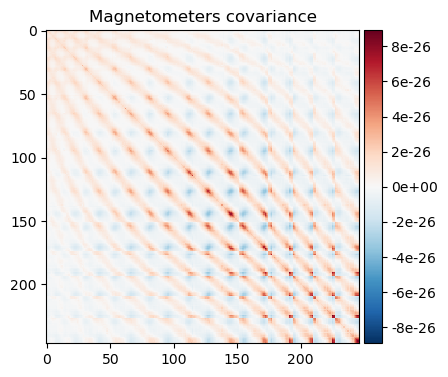

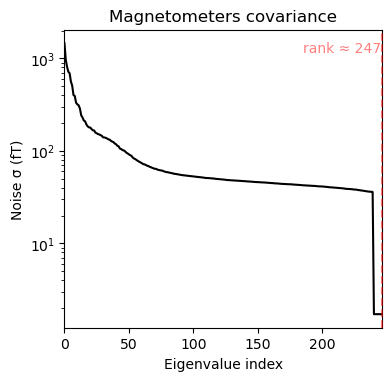

(<Figure size 380x370 with 2 Axes>, <Figure size 380x370 with 1 Axes>)

In [154]:
# getting the data covariance matrix
data_cov = mne.compute_covariance(reading, tmin=0.0, tmax=0.5, method="auto")
data_cov.plot(reading.info)


In [155]:
# computing the spatial filter using unit-noise gain beamfromer to deal with depth bias
filters = make_lcmv(
    evoked_reading.info,
    fwd,
    data_cov,
    reg=0.1,
    noise_cov=noise_cov,
    pick_ori="max-power",
    weight_norm="unit-noise-gain",
    rank="info",  # Use the rank from the info structure to ensure consistency
    reduce_rank=True,
)

filters_vec = make_lcmv(
    evoked_reading.info,
    fwd,
    data_cov,
    reg=0.05, 
    noise_cov=noise_cov,
    pick_ori="vector",
    weight_norm="unit-noise-gain-invariant",
    rank="info",
    reduce_rank=True,
)

Computing rank from covariance with rank='info'
    MAG: rank 247 after 0 projectors applied to 247 channels
Computing rank from covariance with rank='info'
    MAG: rank 247 after 0 projectors applied to 247 channels
Making LCMV beamformer with rank {'mag': 247}
Computing inverse operator with 247 channels.
    247 out of 247 channels remain after picking
Selected 247 channels
Whitening the forward solution.
Computing rank from covariance with rank={'mag': 247}
    Setting small MAG eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matrix.


/var/folders/f1/tvmmnqs17399g3n7wyy0pq0c0000gn/T/ipykernel_71284/429208032.py:2: RuntimeWarning: The largest eigenvalue of the 247-channel mag covariance (rank=247) is over 10 orders of magnitude larger than the smallest (1.77e-24 > 1e10 * -7.79e-42), the resulting whitener will likely be unstable
  filters = make_lcmv(
/var/folders/f1/tvmmnqs17399g3n7wyy0pq0c0000gn/T/ipykernel_71284/429208032.py:2: RuntimeWarning: The largest eigenvalue of the 247-channel mag covariance (rank=247) is over 10 orders of magnitude larger than the smallest (1.77e-24 > 1e10 * -7.79e-42), the resulting whitener will likely be unstable
  filters = make_lcmv(


Computing beamformer filters for 20484 sources
Filter computation complete
Computing rank from covariance with rank='info'
    MAG: rank 247 after 0 projectors applied to 247 channels
Computing rank from covariance with rank='info'
    MAG: rank 247 after 0 projectors applied to 247 channels
Making LCMV beamformer with rank {'mag': 247}
Computing inverse operator with 247 channels.
    247 out of 247 channels remain after picking
Selected 247 channels
Whitening the forward solution.
Computing rank from covariance with rank={'mag': 247}
    Setting small MAG eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matrix.
Computing beamformer filters for 20484 sources


/var/folders/f1/tvmmnqs17399g3n7wyy0pq0c0000gn/T/ipykernel_71284/429208032.py:14: RuntimeWarning: The largest eigenvalue of the 247-channel mag covariance (rank=247) is over 10 orders of magnitude larger than the smallest (1.77e-24 > 1e10 * -7.79e-42), the resulting whitener will likely be unstable
  filters_vec = make_lcmv(
/var/folders/f1/tvmmnqs17399g3n7wyy0pq0c0000gn/T/ipykernel_71284/429208032.py:14: RuntimeWarning: The largest eigenvalue of the 247-channel mag covariance (rank=247) is over 10 orders of magnitude larger than the smallest (1.77e-24 > 1e10 * -7.79e-42), the resulting whitener will likely be unstable
  filters_vec = make_lcmv(


Filter computation complete


In [156]:
stc = apply_lcmv(evoked_reading, filters)
stc_vec = apply_lcmv(evoked_reading, filters_vec)
del filters, filters_vec

In [157]:
lims = [0.3, 0.45, 0.6]
kwargs = dict(
    src=fwd['src'],
    subject=f"{scaled}_{subject}",
    subjects_dir=subjects_dir,
    initial_time=0.087,
    verbose=True,
)

## Morph back to FSAverage for labels to match

In [ ]:
morph = mne.compute_source_morph(
    src=inverse_operator['src'],
    subject_from=f"{scaled}_{subject}",#morphedfsaveragefoldername, i.e., fsaverage_scaled xxx 
    subject_to='fsaverage',
    # subjects_dir=,#saving directory?
)

morphed_stc = morph.apply(stc)

surface source space present ...
Computing morph matrix...
    Left-hemisphere map read.
    Right-hemisphere map read.
    2 smooth iterations done.
    2 smooth iterations done.
[done]
[done]


In [ ]:
morphed_stc.plot(hemi='split')

Using control points [2265707.44211071 2411240.96553939 3317245.08144494]


qt.qpa.backingstore: Back buffer dpr of 1 doesn't match <NSViewBackingLayer: 0x30f307050> contents scale of 2 - updating layer to match.
qt.qpa.backingstore: Back buffer dpr of 1 doesn't match <NSViewBackingLayer: 0x30f3bc5a0> contents scale of 2 - updating layer to match.
qt.qpa.backingstore: Back buffer dpr of 1 doesn't match <NSViewBackingLayer: 0x30f5c6970> contents scale of 2 - updating layer to match.
qt.qpa.backingstore: Back buffer dpr of 1 doesn't match <NSViewBackingLayer: 0x30f5c7d40> contents scale of 2 - updating layer to match.
qt.qpa.backingstore: Back buffer dpr of 1 doesn't match <NSViewBackingLayer: 0x30f5cc930> contents scale of 2 - updating layer to match.
qt.qpa.backingstore: Back buffer dpr of 1 doesn't match <NSViewBackingLayer: 0x30f5cdbd0> contents scale of 2 - updating layer to match.
qt.qpa.backingstore: Back buffer dpr of 1 doesn't match <NSViewBackingLayer: 0x30f5ce570> contents scale of 2 - updating layer to match.
qt.qpa.backingstore: Back buffer dpr of 1

In [ ]:
# read labels from fsaverage annotation using aparc parcellation
labels = mne.read_labels_from_annot(
    subject='fsaverage', 
    parc='aparc.a2009s', 
    hemi='lh',
    subjects_dir=subjects_dir)
labels


Reading labels from parcellation...
   read 75 labels from /Users/ciprianbangu/mne_data/MNE-fsaverage-data/fsaverage/label/lh.aparc.a2009s.annot


[<Label | fsaverage, 'G_Ins_lg_and_S_cent_ins-lh', lh : 769 vertices>,
 <Label | fsaverage, 'G_and_S_cingul-Ant-lh', lh : 2171 vertices>,
 <Label | fsaverage, 'G_and_S_cingul-Mid-Ant-lh', lh : 1957 vertices>,
 <Label | fsaverage, 'G_and_S_cingul-Mid-Post-lh', lh : 2386 vertices>,
 <Label | fsaverage, 'G_and_S_frontomargin-lh', lh : 932 vertices>,
 <Label | fsaverage, 'G_and_S_occipital_inf-lh', lh : 1277 vertices>,
 <Label | fsaverage, 'G_and_S_paracentral-lh', lh : 2272 vertices>,
 <Label | fsaverage, 'G_and_S_subcentral-lh', lh : 2607 vertices>,
 <Label | fsaverage, 'G_and_S_transv_frontopol-lh', lh : 627 vertices>,
 <Label | fsaverage, 'G_cingul-Post-dorsal-lh', lh : 1098 vertices>,
 <Label | fsaverage, 'G_cingul-Post-ventral-lh', lh : 520 vertices>,
 <Label | fsaverage, 'G_cuneus-lh', lh : 1430 vertices>,
 <Label | fsaverage, 'G_front_inf-Opercular-lh', lh : 1800 vertices>,
 <Label | fsaverage, 'G_front_inf-Orbital-lh', lh : 453 vertices>,
 <Label | fsaverage, 'G_front_inf-Triangul

In [ ]:
label = [label for label in labels if 'G_temporal_inf-lh' in label.name][0]
label

<Label | fsaverage, 'G_temporal_inf-lh', lh : 2536 vertices>

In [ ]:
src = mne.read_source_spaces("/Users/ciprianbangu/mne_data/MNE-fsaverage-data/fsaverage/bem/fsaverage-ico-5-src.fif")
label_time_courses = mne.extract_label_time_course(
    morphed_stc,
    label,
    src=src,
    mode='mean_flip',
    return_generator=False,
)

    Reading a source space...
    [done]
    Reading a source space...
    [done]
    2 source spaces read
Extracting time courses for 1 labels (mode: mean_flip)


In [224]:
import pywt
sampling_rate = 300 # data already downsampled to 300 at this point
log_samples = 100 # we want 100 coefficients
cwt_wavelet_name = 'cmor' # reconstruction wavelet
B = 1.0 # wavelet bandwith (higher means more frequencies at each scale, but less precision in peak timing)
C = 1.0 # central frequency (higher means more oscialltions per time window, meaning higher frequency features per scale)
cwt_wavelet = f'{cwt_wavelet_name}{B}-{C}'
frequencies = np.logspace(np.log10(1), np.log10(sampling_rate/2), log_samples)
sampling_period = 1/sampling_rate
scales = pywt.central_frequency(wavelet=cwt_wavelet)/ (frequencies * sampling_period)
dwt_wavelet_name='db4' # denoizing wavelet 
level=5 # level of decomposition. NB in Dash et al. they use 7, but our signal is shorter, so 5 is max
x = process_channel(
                    signal=label_time_courses,
                    cwt_wavelet=cwt_wavelet,
                    scales=scales,
                    sampling_period=sampling_period,
                    dwt_wavelet_name=dwt_wavelet_name,
                    level=level,
                )

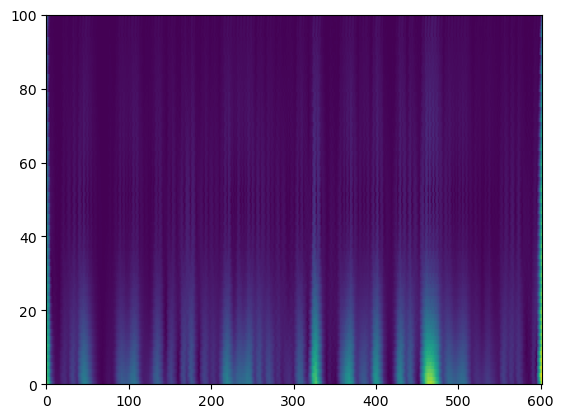

In [179]:
# Reshape x to a 2D array with shape (-1, x.shape[-1]) (flatten all but the last dimension)
x = x.reshape(x.shape[0], x.shape[2], x.shape[1])
x = x.squeeze()
plt.pcolormesh(x)

In [5]:
baseline = mne.io.read_raw_fif("/Volumes/BCOM/ciprian_project/data_analyzed/baselines/BCOM_01/BCOM_01_2_baseline_raw.fif")

Opening raw data file /Volumes/BCOM/ciprian_project/data_analyzed/baselines/BCOM_01/BCOM_01_2_baseline_raw.fif...
    Range : 18384 ... 32784 =     36.768 ...    65.568 secs
Ready.


In [14]:
baseline.pick_types(meg=True)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


<Raw | BCOM_01_2_baseline_raw.fif, 247 x 14401 (28.8 s), ~554 kB, data not loaded>

In [181]:
baseline.pick([ch for ch in baseline.ch_names if ch in data.data[subject]['sa_52'].ch_names])

<Raw | BCOM_01_2_baseline_raw.fif, 247 x 14401 (28.8 s), ~554 kB, data not loaded>

In [182]:
baseline_data = baseline.get_data()

In [1]:
from mne.time_frequency import tfr_morlet
from mne.time_frequency import tfr_multitaper

freqs = np.logspace(np.log10(1), np.log10(150), 100)  # Frequency range
n_cycles = freqs / 2  # Number of cycles per frequency
power = tfr_morlet(data.data[subject]['ta_62'][0], freqs=freqs, n_cycles=n_cycles, return_itc=False)
power.plot([0])  # Plot for the first channel

freqs = np.arange(6, 100, 2)  # Frequency range
n_cycles = freqs / 2  # Adjust n_cycles to match the length of freqs
power = tfr_multitaper(data.data[subject]['ta_62'][0], freqs=freqs, n_cycles=n_cycles, time_bandwidth=2.0, return_itc=False)
power.plot([0])  # Plot for the first channel

evoked = data.data[subject]['ta_62'].average()
power = tfr_morlet(evoked, freqs=freqs, n_cycles=n_cycles, return_itc=False)
power.plot([0])

power.plot_topomap(tmin=0.1, tmax=0.3, fmin=8, fmax=150, ch_type='mag')


power.plot_joint(baseline=(-0.4, -0.2), mode='logratio', fmin=8, fmax=150)


NameError: name 'np' is not defined

In [217]:
sensor = 4

In [218]:
y = process_channel(
                    signal=data.data[subject]['ta_62'][0]._data.squeeze(0)[sensor],
                    cwt_wavelet=cwt_wavelet,
                    scales=scales,
                    sampling_period=sampling_period,
                    dwt_wavelet_name=dwt_wavelet_name,
                    level=level,
                )

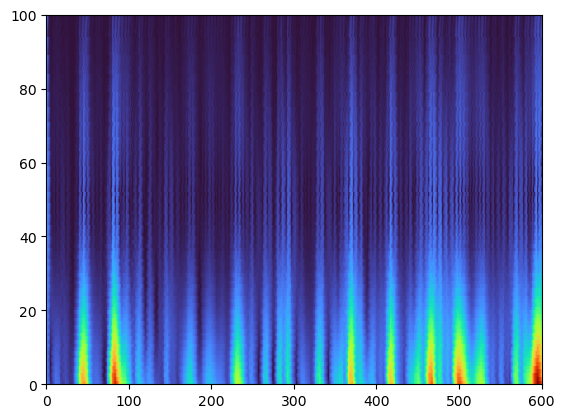

In [202]:
plt.pcolormesh(y, cmap="turbo")

In [225]:
b = process_channel(
                    signal=baseline_data[sensor],
                    cwt_wavelet=cwt_wavelet,
                    scales=scales,
                    sampling_period=sampling_period,
                    dwt_wavelet_name=dwt_wavelet_name,
                    level=level,
                )

In [2]:
b.shape

NameError: name 'b' is not defined

In [204]:
row_wise_mean = b.mean(axis=1, keepdims=True)
row_wise_std = b.std(axis=1, keepdims=True)

In [205]:
y_adjust = 10 * np.log10(y/row_wise_mean)

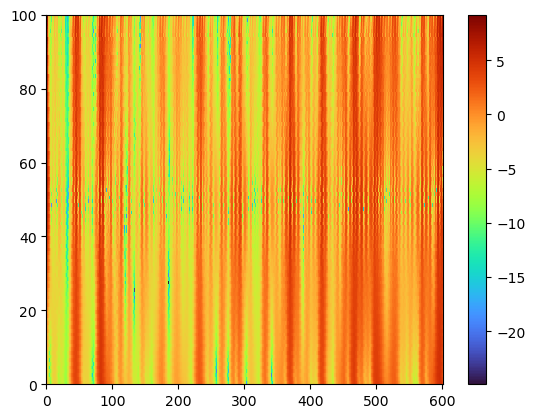

In [206]:
plt.pcolormesh(y_adjust, cmap="turbo")
plt.colorbar()

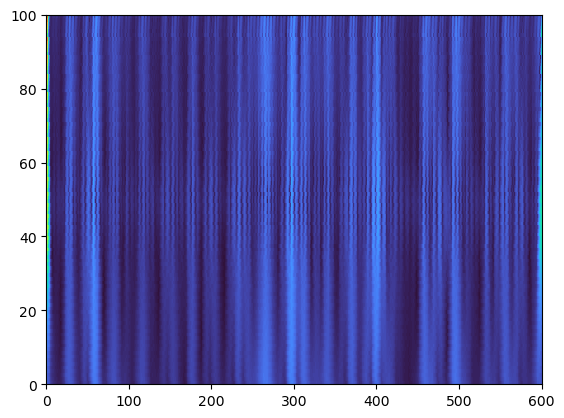

In [219]:
y_adjust =  (y - b.mean(axis=1, keepdims=True))/b.std(axis=1, keepdims=True)
plt.pcolormesh(y_adjust, cmap="turbo")

In [112]:
from scipy.stats import zscore

# Compute the z-score for the entire array
zscored_array = zscore(y, axis=None)  # axis=None computes z-score for the entire array

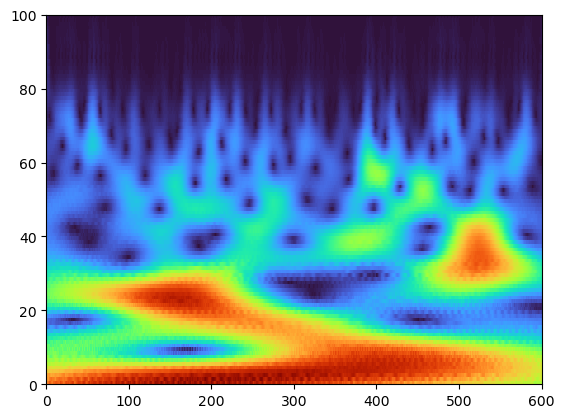

In [114]:
plt.pcolormesh(zscored_array, cmap="turbo")

In [1]:
import mne
import os
from mne.preprocessing import ICA
from mne.preprocessing import create_eog_epochs, create_ecg_epochs
from mne.preprocessing import read_ica
from mne.beamformer import apply_lcmv, make_lcmv
from preprocessing import Preprocessing
from mne import compute_raw_covariance
from datahandling import BcomMEG
from wavelets import *
import matplotlib.pyplot as plt

In [1]:
import mne
import os
import numpy as np
from wavelets import process_channel, save_coefficient_results
from mne import set_config
from argparse import ArgumentParser
from datahandling import BcomMEG
import pywt

subjects=["BCOM_01_3"]

############################
    # CWT setup #
############################

sampling_rate = 500 # data already downsampled to 500 at this point
log_samples = 100 # we want 100 coefficients
cwt_wavelet_name = 'cmor' # reconstruction wavelet
B = 1.0 # wavelet bandwith (higher means more frequencies at each scale, but less precision in peak timing)
C = 1.0 # central frequency (higher means more oscialltions per time window, meaning higher frequency features per scale)
cwt_wavelet = f'{cwt_wavelet_name}{B}-{C}'
frequencies = np.logspace(np.log10(1), np.log10(sampling_rate/2), log_samples)
sampling_period = 1/sampling_rate
scales = pywt.central_frequency(wavelet=cwt_wavelet)/ (frequencies * sampling_period)
dwt_wavelet_name='db4' # denoizing wavelet 
level=5

###########################
    # Labels #
###########################
# get fsaverage
subjects_dir = os.path.dirname(mne.datasets.fetch_fsaverage(verbose=True))

# set_config("SUBJECTS_DIR", subjects_dir, set_env=True)

#get labels
labels_hcp = mne.read_labels_from_annot(
subject='fsaverage',
parc='HCPMMP1',
hemi='lh',
subjects_dir=subjects_dir
)

labels_aparc = mne.read_labels_from_annot(
subject='fsaverage',
parc='aparc',
hemi='lh',
subjects_dir=subjects_dir
)

# from from Sheets et al. 2021 
sma_labels = [label for label in labels_hcp if 'L_6ma_ROI-lh' in label.name][0] +\
    [label for label in labels_hcp if 'L_6mp_ROI-lh' in label.name][0] +\
    [label for label in labels_hcp if 'L_SCEF_ROI-lh' in label.name][0] +\
    [label for label in labels_hcp if 'L_SFL_ROI-lh' in label.name][0]


# commonly attirbuted
broca_labels = [label for label in labels_hcp if "L_44_ROI-lh" in label.name][0] +\
    [label for label in labels_hcp if "L_45_ROI-lh" in label.name][0]


# in the name
stg_labels = [label for label in labels_aparc if 'superiortemporal-lh' in label.name][0]

# in the name
mtg_labels = [label for label in labels_aparc if 'middletemporal-lh' in label.name][0]

# from Eckert et al. 2021
spt_labels = [label for label in labels_hcp if 'PSL' in label.name][0]


label_dictionary = {
"sma": sma_labels,
"broca": broca_labels,
"stg": stg_labels,
"mtg": mtg_labels,
"spt": spt_labels,
}

##################################
# Setting up fsaverage source space #
##################################

fs_average_source_space = mne.setup_source_space(
subject='fsaverage', # only once, no co-registration
spacing='ico5',
add_dist=False,
)

##############################
# Block-wise forward solution #
##############################

bad_localization_channel = "MEG 173"

data_dir = "/Volumes/BCOM/ciprian_project/data_analyzed/non_normalized/data/WITHOUT_BADS/COVERT"
avoid_reading=False
avoid_producing=True

data = BcomMEG(dir=data_dir,
        subjects=subjects,
        avoid_reading=avoid_reading,
        avoid_producing=avoid_producing,
        )

scaled = "scaled_fsaverage"

for subject in data.data: # loop through the subjects (blocks, really)
    
    # we have the morphed transformations, so we will load them for the subject
    morphed_trans = f"/Users/ciprianbangu/Cogmaster/M2 Internship/BCI code/trans/{subject}-trans.fif"
    morphed_source = f"/Users/ciprianbangu/mne_data/MNE-fsaverage-data/{scaled}_{subject}/bem/{scaled}_{subject}-ico-5-src.fif"
    morphed_bem = f"/Users/ciprianbangu/mne_data/MNE-fsaverage-data/{scaled}_{subject}/bem/{scaled}_{subject}-5120-5120-5120-bem-sol.fif"
    
    # forward solution by block
    first_epoch_name = list(data.data[subject].keys())[0]
    fwd_solution_epoch = data.data[subject][first_epoch_name]

    fwd_solution = mne.make_forward_solution(
        fwd_solution_epoch.info,
        trans=morphed_trans,
        src=morphed_source,
        bem=morphed_bem,
        meg=True,
        eeg=False,
    )

    #####################
    # noise covariance #
    ####################
    empty_room_dir = "/Volumes/BCOM/ciprian_project/data_analyzed/preprocessed"
    # need to get the covariance matrix from the empty_room recording 
    subject_empty_room = os.path.join(empty_room_dir, subject[:7], subject[-1], "empty_room_cleaned_ICA_raw.fif")

    empty_room_raw = mne.io.read_raw_fif(
        subject_empty_room,
        preload=True,
    )
    
    empty_room_raw.interpolate_bads(exclude=[bad_localization_channel], origin=(0., 0., 0.))
    
    noise_cov = mne.compute_raw_covariance(
        empty_room_raw,
        method="auto",
        rank="info",
        picks="meg",
    )

    #################
    # get baseline #
    ################
    sub = subject[:7]
    block = subject[-1]

    baseline_dir = "/Volumes/BCOM/ciprian_project/data_analyzed/baselines"

    subject_baseline = os.path.join(baseline_dir, sub, f"{subject}_baseline_raw.fif")
    baseline = mne.io.read_raw_fif(subject_baseline, preload=True)
    baseline.pick_types(meg=True)


    ###################
    # data covariance #
    ###################
    
    raw = mne.io.read_raw_fif(fname=f"/Volumes/BCOM/ciprian_project/data_analyzed/preprocessed/{sub}/{block}/subject_cleaned_ica_raw.fif")
    
    epochs_array = []
    dropped_epochs = []

    covert_dir = "/Volumes/BCOM/ciprian_project/data_analyzed/non_normalized/data/WITHOUT_BADS/COVERT"
    overt_dir = "/Volumes/BCOM/ciprian_project/data_analyzed/non_normalized/data/WITHOUT_BADS/OVERT"
    
    for file in os.listdir(covert_dir):
        if subject in file:
            file_path = os.path.join(covert_dir, file)
            epoch = mne.read_epochs(file_path)
            if epoch.info['dev_head_t'] != raw.info['dev_head_t']:
                dropped_epochs.append(("Covert", file, len(epoch.events)))
            else:
                epochs_array.append(epoch)

    for file in os.listdir(overt_dir):
        if subject in file:
            file_path = os.path.join(covert_dir, file)
            epoch = mne.read_epochs(file_path)
            if epoch.info['dev_head_t'] != raw.info['dev_head_t']:
                dropped_epochs.append(("Overt", file, len(epoch.events)))
            else:
                epochs_array.append(epoch)                 
            
    epochs_array = mne.concatenate_epochs(epochs_array)


    data_cov = mne.compute_covariance(
            epochs_array.crop(tmin=-0.2, tmax=0.6), 
            method="auto", 
            rank="info"
        )


    ####################
    #    beamforming   #
    ####################

    filters = mne.beamformer.make_lcmv(
            epochs_array.info,
            fwd_solution,
            data_cov,
            reg=0.05,
            noise_cov=noise_cov,
            pick_ori="max-power",
            weight_norm="unit-noise-gain",
            rank="info",
            reduce_rank=True,
    )


    del epochs_array
    del raw

    ###########################
    # now on the actual data # 
    ###########################

    recon_baseline = mne.beamformer.apply_lcmv_raw(baseline, filters)

    morph = mne.compute_source_morph(
        src=morphed_source,
        subject_from=f"{scaled}_{subject}",
        subject_to="fsaverage",
        subjects_dir=subjects_dir,
    )

    morphed_baseline = morph.apply(recon_baseline)


    for syllable in data.data[subject]:
        data.data[subject][syllable].crop(tmin=-0.2, tmax=0.6)

        recon_task = mne.beamformer.apply_lcmv_epochs(data.data[subject][syllable], filters)

        morphed_time_courses = [morph.apply(stc) for stc in recon_task]

        n_time_points = data.data[subject][syllable][0].copy().get_data().shape[-1]
    
        roi_array = np.zeros([len(label_dictionary), len(data.data[subject][syllable]), log_samples, n_time_points])
        
        for i, label in enumerate(label_dictionary):
            print(f"getting timecourse for {label}")

            label_time_courses_condition = mne.extract_label_time_course(
                morphed_time_courses,
                label_dictionary[label],
                src=fs_average_source_space,
                mode="mean_flip",
                return_generator=False,
            )

            label_time_course_baseline = mne.extract_label_time_course(
                morphed_baseline,
                label_dictionary[label],
                src=fs_average_source_space,
                mode="mean_flip",
                return_generator=False,
            )

            baseline_tf = process_channel(
                signal=label_time_course_baseline,
                cwt_wavelet=cwt_wavelet,
                scales=scales,
                sampling_period=sampling_period,
                dwt_wavelet_name=dwt_wavelet_name,
                level=level,
            )

            reshaped_baseline = np.transpose(baseline_tf, (0, 2, 1))
            reshaped_baseline = reshaped_baseline.squeeze()
            reshaped_baseline = reshaped_baseline[:, :label_time_course_baseline.shape[1]]

            baseline_row_mean = reshaped_baseline.mean(axis=1, keepdims=True)
            baseline_row_std = reshaped_baseline.std(axis=1, keepdims=True)

            print("baseline computed")
            
            for j, tc in enumerate(label_time_courses_condition):
                result_condition = process_channel(
                    signal=tc,
                    cwt_wavelet=cwt_wavelet,
                    scales=scales,
                    sampling_period=sampling_period,
                    dwt_wavelet_name=dwt_wavelet_name,
                    level=level,
                )

                reshaped_result = np.transpose(result_condition, (0, 2, 1))
                reshaped_result = reshaped_result.squeeze()
                reshaped_result = reshaped_result[:, :tc.shape[1]] 

                normalized_result = (reshaped_result - baseline_row_mean) / baseline_row_std

                roi_array[i, j] = normalized_result

                print(f"{j+1} out of {len(label_time_courses_condition)} computed")

            print(f"{label} computed")
            
            save_coefficient_results(
                subject=subject,
                syllable=syllable,
                all_coefficients=roi_array,
                save_dir=os.getcwd()
                )
            break
        break
    break












                 



0 files missing from root.txt in /Users/ciprianbangu/mne_data/MNE-fsaverage-data
0 files missing from bem.txt in /Users/ciprianbangu/mne_data/MNE-fsaverage-data/fsaverage
Reading labels from parcellation...
   read 181 labels from /Users/ciprianbangu/mne_data/MNE-fsaverage-data/fsaverage/label/lh.HCPMMP1.annot
Reading labels from parcellation...
   read 35 labels from /Users/ciprianbangu/mne_data/MNE-fsaverage-data/fsaverage/label/lh.aparc.annot
Setting up the source space with the following parameters:

SUBJECTS_DIR = /Users/ciprianbangu/mne_data/MNE-fsaverage-data
Subject      = fsaverage
Surface      = white
Icosahedron subdivision grade 5

>>> 1. Creating the source space...

Doing the icosahedral vertex picking...
Loading /Users/ciprianbangu/mne_data/MNE-fsaverage-data/fsaverage/surf/lh.white...
Mapping lh fsaverage -> ico (5) ...
    Triangle neighbors and vertex normals...
Loading geometry from /Users/ciprianbangu/mne_data/MNE-fsaverage-data/fsaverage/surf/lh.sphere...
Setting u

In [3]:
epoch = mne.read_epochs("/Volumes/BCOM/ciprian_project/data_analyzed/non_normalized/data/WITHOUT_BADS/COVERT/BCOM_01_2_a_12-epo.fif")

Reading /Volumes/BCOM/ciprian_project/data_analyzed/non_normalized/data/WITHOUT_BADS/COVERT/BCOM_01_2_a_12-epo.fif ...
    Found the data of interest:
        t =    -400.00 ...     800.00 ms
        0 CTF compensation matrices available
Not setting metadata
17 matching events found
No baseline correction applied
0 projection items activated


No projector specified for this dataset. Please consider the method self.add_proj.


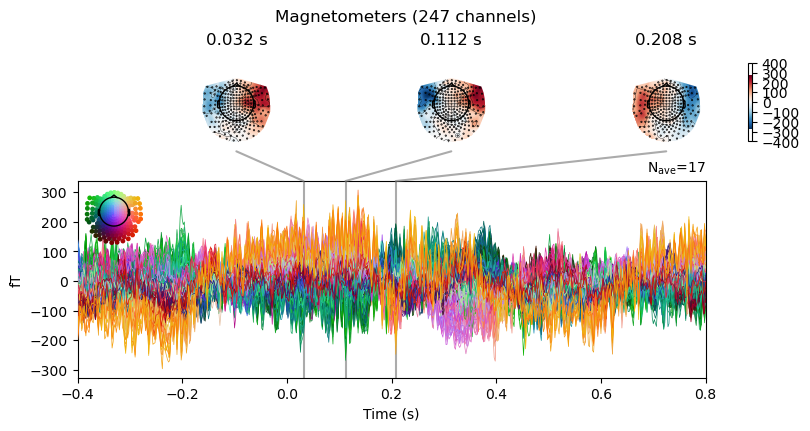

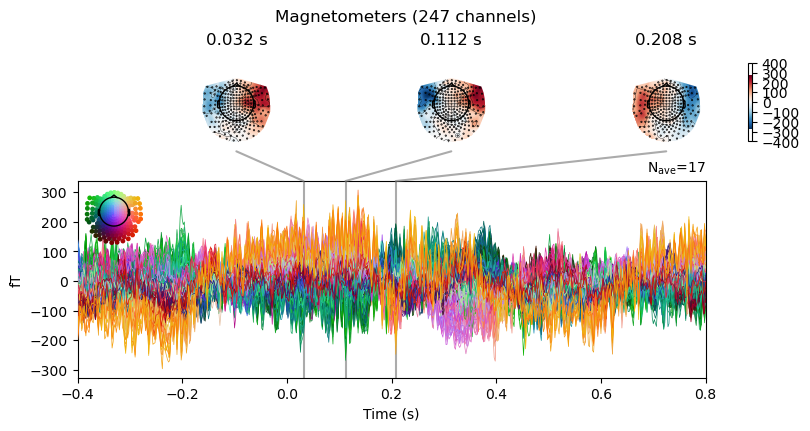

In [7]:
epoch.average().plot_joint()